In [2]:
# Set up the notebook paths
import notebook_setup
repo_root = notebook_setup.setup_paths()

# Core jax
import jax
import jax.numpy as np
import jax.random as jr
from jax import config as jax_config, tree as jtree

# Optimisation
import equinox as eqx
import zodiax as zdx
import optax

# dLuxShera optimisation helpers
from Classes.optimization import (
    get_optimiser,
    get_lr_from_curvature,
    loss_fn,
    step_fn,
    step_fn_eigen,
    step_fn_general,
    construct_priors_from_dict,
    loss_with_injected,
    ModelParams,
    SheraThreePlaneParams,
    EigenParams,
    FIM,
    generate_fim_labels,
    pack_params,
    unpack_params,
    build_basis,
)

from Classes.modeling import SheraThreePlane_Model
from Classes.utils import (
    calculate_log_flux,
    set_array,
)
from Classes.plotting import (
    merge_cbar,
    plot_psf_comparison,
    plot_parameter_history,
    choose_subplot_grid,
)

# Plotting / visualisation
import numpy as onp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colormaps
from tqdm.notebook import tqdm
import time, datetime, os


# Colormaps and matplotlib defaults
inferno = mpl.colormaps["inferno"]
seismic = mpl.colormaps["seismic"]
coolwarm = mpl.colormaps["coolwarm"]
# Set NaNs to display as grey
inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
coolwarm.set_bad("k", 0.5)

plt.rcParams["image.cmap"]   = "inferno"
plt.rcParams["font.family"]  = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"]   = 120

# Enable 64-bit in JAX
jax_config.update("jax_enable_x64", True)


Repo root set to: /Users/Dmckeith/Documents/GitHub/dLuxShera
CWD: /Users/Dmckeith/Documents/GitHub/dLuxShera/Examples/notebooks


In [3]:
################################
## Main Simulation Parameters ##
################################

t0_script = time.time()
project_root = os.path.abspath("..")  # parent of Examples/notebooks
save_path = os.path.join(project_root, "Results")

script_name = "Shera_Eigen_Inference_Example"
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"Starting Simulation: {script_name} - {timestamp}")

# Plotting / Saving Settings
present_plots  = True    # show figures in notebook
print2console  = True

# -------------------
# Eigenmode Options
# -------------------
use_eigen       = True      # Enables eigenmode re-parameterization
whiten_basis    = True      # Scales eigenvectors by 1/sqrt(lambda)
truncate_k      = None      # Integer or None, truncates to top k modes
truncate_by_eigval = 1e4    # Only used if truncate_k is None

# Observation Settings
exposure_time      = 1800   # sec
frame_rate = 20  # Hz, observation frame rate
exposure_per_frame = 1 / frame_rate  # seconds
N_frames = frame_rate * exposure_time  # frames


# Noise Settings
add_shot_noise = False
sigma_read     = 0.0

# -------------------
# Default Shera params
# -------------------
point_design   = "shera_testbed" # "shera_testbed" or "shera_flight"
default_params = SheraThreePlaneParams(point_design=point_design)
default_params = default_params.set("rng_seed", 0)

# Calculate flux according to Star + System parameters
log_flux = calculate_log_flux(
    default_params.p1_diameter,
    default_params.bandwidth / 1000,
    exposure_time,
)
default_params = default_params.set("log_flux", log_flux)

# -------------------
# Data parameter container
# -------------------
data_initial_params = ModelParams({
    "pupil_npix": 256,
    "psf_npix":   256,
    "wavelength": 550.0,
    "n_wavelengths": 3,

    # Astrometry
    "x_position":      0.0,
    "y_position":      0.0,
    "separation":      10.0,
    "position_angle":  90.0,
    "contrast":        0.3,
    "pixel_size":      6.5e-6,

    # Zernikes
    "m1_zernike_noll": np.arange(4, 12),
    "m1_zernike_amp":  np.zeros(8),
    "m2_zernike_noll": np.arange(4, 12),
    "m2_zernike_amp":  np.zeros(8),

    # Calibrated 1/f WFE
    "m1_calibrated_power_law": 2.5,
    "m1_calibrated_amplitude": 0.0,
    "m2_calibrated_power_law": 2.5,
    "m2_calibrated_amplitude": 0.0,

    # Uncalibrated 1/f WFE
    "m1_uncalibrated_power_law": 2.5,
    "m1_uncalibrated_amplitude": 0.0,
    "m2_uncalibrated_power_law": 2.5,
    "m2_uncalibrated_amplitude": 0.0,
})

# -------------------
# Model parameter container
# -------------------
model_initial_params = ModelParams({
    "pupil_npix": 256,
    "psf_npix":   256,
    "wavelength": 550.0,
    "n_wavelengths": 3,

    "x_position":      0.0,
    "y_position":      0.0,
    "separation":      10.0,
    "position_angle":  90.0,
    "contrast":        0.3,
    "pixel_size":      6.5e-6,

    "m1_zernike_noll": np.arange(4, 12),
    "m1_zernike_amp":  np.zeros(8),
    "m2_zernike_noll": np.arange(4, 12),
    "m2_zernike_amp":  np.zeros(8),

    "m1_calibrated_power_law": 2.5,
    "m1_calibrated_amplitude": 0.0,
    "m2_calibrated_power_law": 2.5,
    "m2_calibrated_amplitude": 0.0,
})


Starting Simulation: Shera_Eigen_Inference_Example - 20251119_164258


In [4]:
# Priors
prior_info = {
    "x_position":                 (1e-2, "Normal"),     # as
    "y_position":                 (1e-2, "Normal"),     # as
    "separation":                 (1e-4, "Normal"),     # as
    "position_angle":             (1e-3, "Uniform"),    # deg
    "log_flux":                   (1e-3, "LogNormal"),  # log10(flux)
    "contrast":                   (1e-3, "LogNormal"),  # unitless (B:A)
    "psf_pixel_scale":            (1e-3, "LogNormal"),  # as/pix
    "m1_aperture.coefficients":   (5.0,  "Normal"),     # nm
    "m2_aperture.coefficients":   (5.0,  "Normal"),     # nm
}

# Optimisation settings
n_iter = 100
lr     = 0.5
opt    = optax.sgd(lr)
optimiser_label = "optax.sgd"

optimisers = {
    "separation":               opt,
    "position_angle":           opt,
    "x_position":               opt,
    "y_position":               opt,
    "log_flux":                 opt,
    "contrast":                 opt,
    "psf_pixel_scale":          opt,
    "m1_aperture.coefficients": opt,
    "m2_aperture.coefficients": opt,
}
params = list(optimisers.keys())
print("Parameters included in FIM/optimization:")
print(params)


Parameters included in FIM/optimization:
['separation', 'position_angle', 'x_position', 'y_position', 'log_flux', 'contrast', 'psf_pixel_scale', 'm1_aperture.coefficients', 'm2_aperture.coefficients']


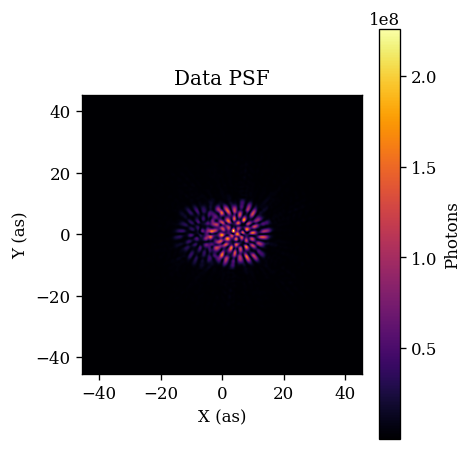


Calculating Fisher Information Matrix...
FIM shape: (23, 23)


In [15]:
######################
## Simulation Start ##
######################

t0_simulation = time.time()
rng_key = jr.PRNGKey(default_params.rng_seed)

path_map    = default_params.get_param_path_map()
inv_path_map = {v: k for k, v in path_map.items()}

# Create data & model objects
data_params = data_initial_params.inject(default_params)
data_model  = SheraThreePlane_Model(data_params)

initial_model_params = model_initial_params.inject(default_params)
model = SheraThreePlane_Model(initial_model_params)

# Data PSF
data_psf = data_model.model()

# Optional: quick PSF sanity plot
plt.figure(figsize=(4, 4))
psf_extent_as = model.psf_npixels * model.psf_pixel_scale / 2 * np.array([-1, 1, -1, 1])
plt.imshow(data_psf, extent=psf_extent_as)
plt.title("Data PSF")
plt.xlabel("X (as)")
plt.ylabel("Y (as)")
plt.colorbar(label="Photons")
plt.tight_layout()
plt.show()

# Build priors centered on current values
prior_info = {
    k: {
        "mean": model.get(k if k not in path_map else path_map[k]),
        "sigma": v[0],
        "dist": v[1],
    }
    for k, v in prior_info.items()
}
priors = construct_priors_from_dict(prior_info)

# Some masks & extents needed later
m1_mask    = model.m1_aperture.transmission
m1_nanmask = np.where(m1_mask, m1_mask, np.nan)
m2_mask    = model.m2_aperture.transmission
m2_nanmask = np.where(m2_mask, m2_mask, np.nan)

pupil_extent_mm = model.diameter * 1e3 / 2 * np.array([-1, 1, -1, 1])
m2_extent_mm    = model.p2_diameter * 1e3 / 2 * np.array([-1, 1, -1, 1])

# FIM calculation uses model_psf and its variance
model_psf = model.model()

print("\nCalculating Fisher Information Matrix...")
fim = FIM(
    model,      # model pytree
    params,     # list of parameter names
    loss_fn,    # negative log-likelihood
    model_psf,  # model output
    model_psf,  # variance proxy (for now)
)
print("FIM shape:", fim.shape)

fim_labels = generate_fim_labels(params, initial_model_params)


Truncating eigenmodes by λ≥10000 → keeping 15/23 modes

Dominant pure-parameter contribution per eigenmode:
mode   lambda_k        |v|max    dominant_pure_param
-----------------------------------------------------
   0     2.768e+14   9.998e-01   psf_pixel_scale
   1     1.074e+12   1.000e+00   log_flux
   2     4.048e+11   9.385e-01   y_position
   3     3.880e+11   8.986e-01   x_position
   4     1.907e+11   9.969e-01   contrast
   5     4.043e+10   9.577e-01   separation
   6     1.678e+09   9.981e-01   position_angle
   7     3.587e+07   9.658e-01   M1 Z9
   8     2.225e+07   7.945e-01   M1 Z7
   9     2.067e+07   7.938e-01   M1 Z8
  10     1.846e+07   9.272e-01   M1 Z10
  11     1.699e+07   7.671e-01   M1 Z4
  12     1.037e+07   8.938e-01   M1 Z11
  13     9.555e+06   9.769e-01   M1 Z6
  14     8.725e+06   9.757e-01   M1 Z5
  15     6.930e+02   8.491e-01   M2 Z11
  16     1.389e+02   9.879e-01   M2 Z6
  17     1.143e+02   9.876e-01   M2 Z5
  18     3.756e+01   9.773e-01   M2 Z8
 

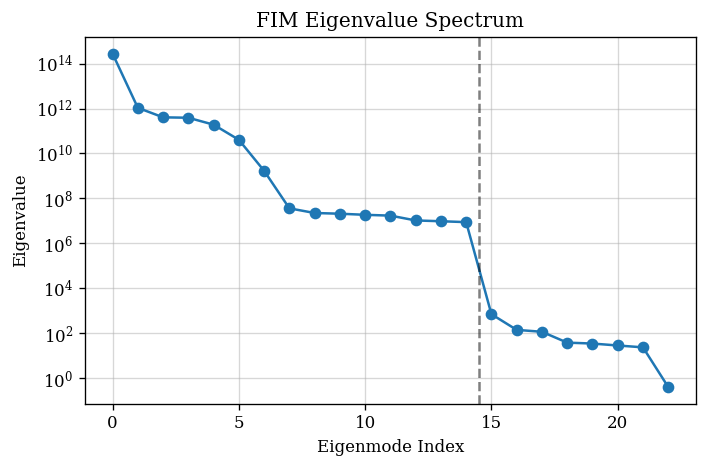

p_ref shape: (23,)
Basis B shape: (23, 15)


In [17]:
# --- Eigen decomposition of FIM ---
eigvals, eigvecs = np.linalg.eigh(fim)

# Sort from largest to smallest
sorted_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

# Truncation logic
if (truncate_k is None) and (truncate_by_eigval is not None):
    ev_bool = eigvals >= truncate_by_eigval
    k = int(np.count_nonzero(ev_bool))
    if k == 0:
        k = 1
    elif k > eigvals.size:
        k = eigvals.size
    truncate_k = k
    print(f"Truncating eigenmodes by λ≥{truncate_by_eigval:g} → keeping {truncate_k}/{eigvals.size} modes")

# Dominant pure-parameter explanation per eigenmode
pure_labels = list(fim_labels)
V = onp.asarray(eigvecs)                     # (P x P)
dom_idx   = onp.argmax(onp.abs(V), axis=0)
dom_label = [pure_labels[i] for i in dom_idx]
dom_mag   = onp.max(onp.abs(V), axis=0)

print("\nDominant pure-parameter contribution per eigenmode:")
print("mode   lambda_k        |v|max    dominant_pure_param")
print("-----------------------------------------------------")
for k in range(len(eigvals)):
    print(f"{k:4d}   {eigvals[k]:11.3e}   {dom_mag[k]:9.3e}   {dom_label[k]}")

# Eigenvalue spectrum plot (quick)
plt.figure(figsize=(6, 4))
plt.semilogy(eigvals, marker="o")
plt.title("FIM Eigenvalue Spectrum")
plt.xlabel("Eigenmode Index")
plt.ylabel("Eigenvalue")
plt.grid(True, which="both", alpha=0.5)
if truncate_k is not None:
    plt.axvline(truncate_k - 0.5, color="k", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Build reference parameter vector and eigen basis ---
p_ref, _ = pack_params(initial_model_params, params, initial_model_params)
B = build_basis(eigvecs, eigvals, truncate=truncate_k, whiten=whiten_basis)

print("p_ref shape:", p_ref.shape)
print("Basis B shape:", B.shape)  # (n_pure, k)


In [18]:
##############################
## Single observation setup ##
##############################

# One RNG key for this observation
obs_key = jr.split(rng_key)[0]

# --- Make noisy data image ---
if add_shot_noise:
    obs_key, subkey = jr.split(obs_key)
    if exposure_time >= 7200:   # > 2 hours → Gaussian approx
        photons = np.sqrt(data_psf) * jr.normal(subkey, data_psf.shape) + data_psf
    else:
        photons = jr.poisson(subkey, data_psf)
else:
    photons = data_psf

# Add read noise
obs_key, subkey = jr.split(obs_key)
read_noise = sigma_read * np.sqrt(N_frames) * jr.normal(subkey, data_psf.shape)

data = photons + read_noise

# Variance of each pixel (shot + read)
var = np.maximum(
    data + (sigma_read * np.sqrt(N_frames)) ** 2,
    (sigma_read * np.sqrt(N_frames)) ** 2,
)

# --- True parameter values (for later residuals) ---
true_vals = {param: data_model.get(param) for param in params}
true_vals["raw_fluxes"]      = data_model.raw_fluxes
true_vals["psf_pixel_scale"] = data_model.psf_pixel_scale

# Optional: value + gradient at the true model
val_grad_fn = zdx.filter_value_and_grad(params)(loss_fn)
true_loss, true_grads = val_grad_fn(data_model, data, var)
print(f"True loss: {float(true_loss):.5g}")

# --- Draw perturbations from priors to define starting model ---
print("\nDrawing perturbations from priors:")
obs_key, *subkeys = jr.split(obs_key, len(priors) + 1)
perturbations = {}
initial_vals  = {}

for i, param in enumerate(params):
    sample  = priors[param].sample(subkeys[i])
    nominal = true_vals[param]
    delta   = sample - nominal
    perturbations[param] = delta
    initial_vals[param]  = sample

    if print2console:
        if np.ndim(sample) == 0:
            print(f"{param}: sample={sample:.3g}, nominal={nominal:.3g}, delta={delta:.3g}")
        else:
            sample_str = ", ".join(f"{v:.3g}" for v in np.ravel(sample))
            delta_str  = ", ".join(f"{v:.3g}" for v in np.ravel(delta))
            print(f"{param}: sample=[{sample_str}], delta=[{delta_str}]")

# Apply those perturbations to the model
obs_model = set_array(model.add(params, list(perturbations.values())), params)

initial_loss, initial_grads = val_grad_fn(obs_model, data, var)
print(f"Initial loss (after perturbation): {float(initial_loss):.5g}")

# --- Build eigen-parameter container (EigenParams) ---

# Pack pure parameters for truth and starting model
p_true, _ = pack_params(data_model.extract_params(),   params, initial_model_params)
p_obs,  _ = pack_params(obs_model.extract_params(),    params, initial_model_params)

delta_p_true = p_true - p_ref
delta_p_obs  = p_obs  - p_ref

# Least-squares projection onto eigen basis B
c_true = np.linalg.lstsq(B, delta_p_true, rcond=None)[0]
c0     = np.linalg.lstsq(B, delta_p_obs,  rcond=None)[0]

# Map each pure parameter to its shape so EigenParams can unpack it
shape_map = {
    p: np.shape(initial_model_params.get(inv_path_map.get(p, p)))
    for p in params
}

model_params = EigenParams(
    params={"eigen_coefficients": c0},
    p_ref=onp.array(p_ref),
    B=onp.array(B),
    pure_keys=params,
    shape_map=shape_map,
)

optim = optax.sgd(lr)
state = optim.init(c0)

# Learning-rate model in eigen-space
k = B.shape[1]
curv_vec = eigvals[:k]
if whiten_basis:
    # When whitening, the curvature has been flattened; use a simple scalar 1/lr here
    curv_vec = np.ones_like(curv_vec) / lr

lr_model = get_lr_from_curvature(
    curv_vec,
    model_params,
    order=["eigen_coefficients"],
)

true_vals["eigen_coefficients"]    = c_true
initial_vals["eigen_coefficients"] = c0

# A JITted helper for evaluating loss+grad with injected params (mainly for diagnostics)
loss_value_fn = eqx.filter_jit(
    zdx.filter_value_and_grad(model_params.keys)(
        lambda p, m, d, v: loss_with_injected(p, m, d, v, loss_fn)
    )
)


True loss: 4.863e+05

Drawing perturbations from priors:
separation: sample=10, nominal=10, delta=-0.000182
position_angle: sample=90, nominal=90, delta=-0.000754
x_position: sample=-0.000376, nominal=0, delta=-0.000376
y_position: sample=0.00248, nominal=0, delta=0.00248
log_flux: sample=11.3, nominal=11.3, delta=-0.0265
contrast: sample=0.3, nominal=0.3, delta=0.000388
psf_pixel_scale: sample=0.355, nominal=0.355, delta=0.000254
m1_aperture.coefficients: sample=[5.07, -0.853, 3.22, 3.94, -1.48, -5.18, 2.64, 2.91], delta=[5.07, -0.853, 3.22, 3.94, -1.48, -5.18, 2.64, 2.91]
m2_aperture.coefficients: sample=[-0.202, -2.23, -2.73, 6.88, -11.4, -1.66, 9.3, -1.46], delta=[-0.202, -2.23, -2.73, 6.88, -11.4, -1.66, 9.3, -1.46]
Initial loss (after perturbation): 4.0075e+09


In [19]:
##############################
## Optimization in eigen basis
##############################

step = step_fn_general  # uses EigenParams transparently

t0_optim = time.time()

# History containers: start from the initial values
history = {param: [initial_vals[param]] for param in params}
history["eigen_coefficients"] = [initial_vals["eigen_coefficients"]]

losses     = []
models_out = [obs_model]

for i in tqdm(range(n_iter)):
    loss, raw_grads, scaled_grads, updates, obs_model, model_params, state = step(
        model_params,
        data,
        var,
        obs_model,
        lr_model,
        optim,
        state,
        loss_fn,
    )

    losses.append(loss)
    models_out.append(obs_model)

    # Current eigen coefficients
    c_now = model_params.get("eigen_coefficients")
    history["eigen_coefficients"].append(c_now)

    # Back-project to pure parameter vector and record those too
    p_now       = p_ref + B @ c_now
    pure_params = unpack_params(p_now, params, initial_model_params)
    for p_name, value in pure_params.params.items():
        history.setdefault(p_name, []).append(value)

t1_optim = time.time()
print(f"Finished {n_iter} iterations in {t1_optim - t0_optim:.2f} s")

# Turn lists into arrays for easier plotting
history = {k: np.array(v) for k, v in history.items()}
losses  = np.array(losses)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.67it/s]


Finished 100 iterations in 60.17 s


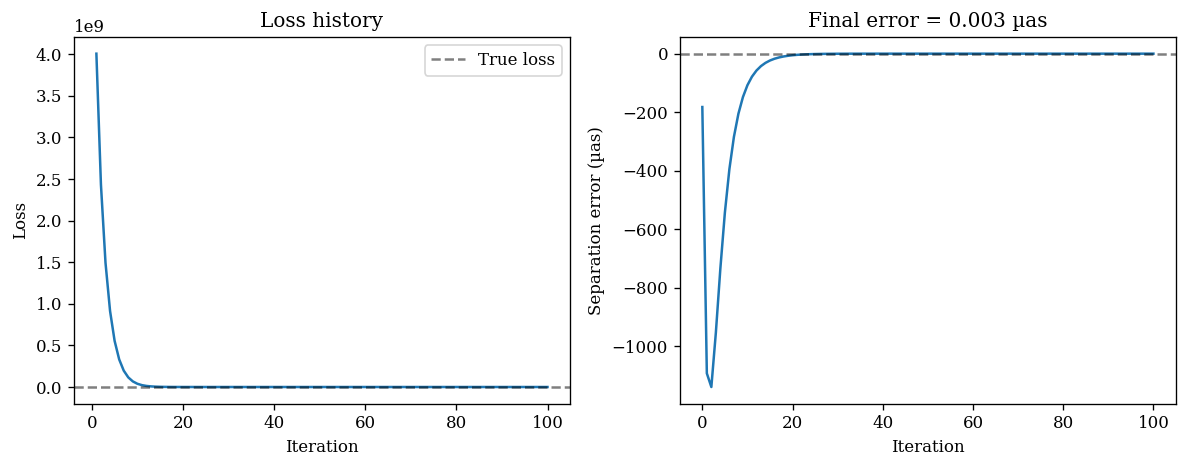

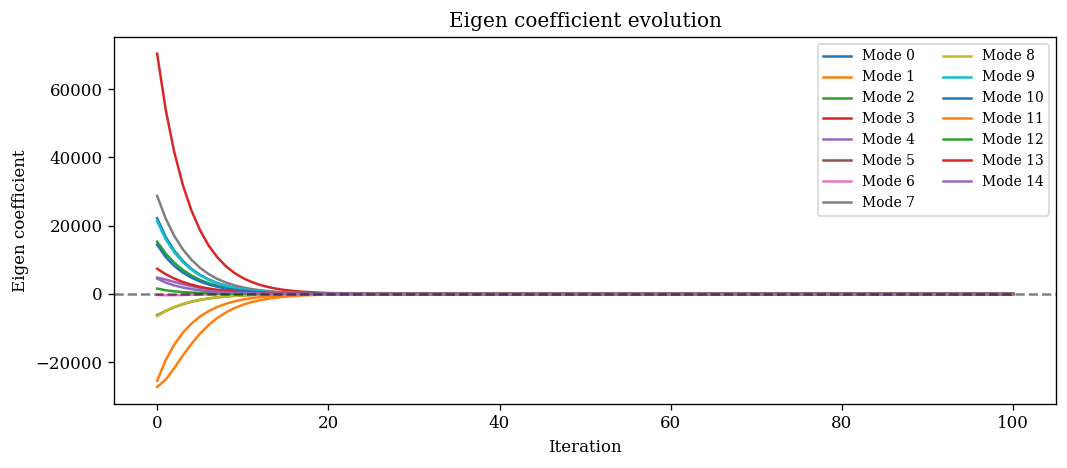

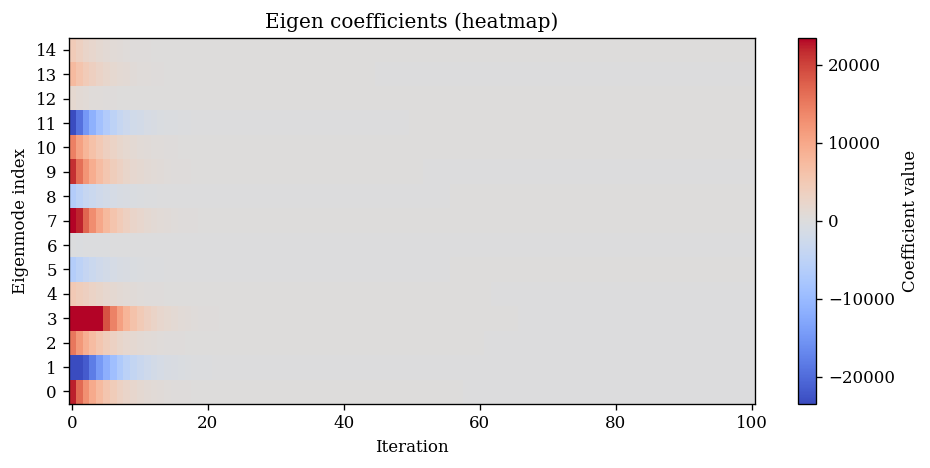

In [20]:
######################################
## Residuals and basic visualisation ##
######################################

# Parameters we'll show as simple scalars
scalar_params = [
    "separation",
    "x_position",
    "y_position",
    "position_angle",
    "log_flux",
    "contrast",
    "psf_pixel_scale",
]

# Build residual dict (history - truth)
residuals = {}
for p in scalar_params:
    residuals[p] = history[p] - true_vals[p]

# Loss vs iteration
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(np.arange(1, n_iter + 1), losses)
axes[0].axhline(float(true_loss), color="k", ls="--", alpha=0.5, label="True loss")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss history")
axes[0].legend()

# Separation error (µas)
sep_err_uas = 1e6 * residuals["separation"]
axes[1].plot(np.arange(sep_err_uas.size), sep_err_uas)
axes[1].axhline(0.0, color="k", ls="--", alpha=0.5)
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Separation error (µas)")
axes[1].set_title(f"Final error = {sep_err_uas[-1]:.3f} µas")

plt.tight_layout()
plt.show()

# --- Eigen coefficient histories ---

coeffs = history["eigen_coefficients"]  # (n_iter+1, k)

plt.figure(figsize=(9, 4))
for j in range(coeffs.shape[1]):
    plt.plot(coeffs[:, j], label=f"Mode {j}")
plt.axhline(0, color="k", ls="--", alpha=0.5)
plt.xlabel("Iteration")
plt.ylabel("Eigen coefficient")
plt.title("Eigen coefficient evolution")
plt.legend(ncol=2, fontsize="small")
plt.tight_layout()
plt.show()

# Heatmap view
plt.figure(figsize=(8, 4))
vmax = np.max(np.abs(coeffs)) / 3.0
plt.imshow(
    coeffs.T,
    aspect="auto",
    origin="lower",
    cmap="coolwarm",
    vmin=-vmax,
    vmax=vmax,
)
plt.colorbar(label="Coefficient value")
plt.xlabel("Iteration")
plt.ylabel("Eigenmode index")
plt.title("Eigen coefficients (heatmap)")
plt.yticks(np.arange(coeffs.shape[1]))
plt.tight_layout()
plt.show()
